In [1]:
import pandas as pd
import sys
sys.path.append('../src')
from models import arima_model, plot_arima_results, plot_acf_pcf

In [4]:
us_cpi_df = pd.read_excel(r"../data/raw/revised-seasonally-adjusted-indexes-2021.xlsx")
excel_df_16_20 = pd.read_excel(r"../data/raw/revised-seasonally-adjusted-indexes-2020.xlsx")
excel_df_15_19 = pd.read_excel(r"../data/raw/revised-seasonally-adjusted-indexes-2019.xlsx")
#we are only keeping the SAESONALLY ADJUSTED INDEX values so it will be dropped to reduce dataset clutter for pivoting
# Also dropping "ITEM" because it provides a code for the item but we will just be mapping based off title, will make the pivoted dataframe easier to read
us_cpi_df = us_cpi_df[(us_cpi_df['DATA_TYPE'] == 'SEASONALLY ADJUSTED INDEX')]

excel_df = pd.concat([excel_df_16_20, excel_df_15_19[excel_df_15_19['YEAR'] == 2015]], ignore_index=True).sort_values(by='YEAR')
us_cpi_df = excel_df[excel_df['DATA_TYPE'] == 'SEASONALLY ADJUSTED INDEX'].drop(columns='DATA_TYPE')

us_cpi_df[us_cpi_df['TITLE'] == 'All items'].sort_values(by='YEAR')

/Users/richardwcheng/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Users/richardwcheng/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Users/richardwcheng/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,ITEM,TITLE,seriesid,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
6450,SA0,All items,CUSR0000SA0,2015,234.747,235.342,235.976,236.222,237.001,237.657,238.034,238.033,237.498,237.733,238.017,237.761
7200,SA0,All items,CWSR0000SA0,2015,229.498,230.264,230.948,231.118,232.035,232.720,233.021,232.967,232.092,232.262,232.491,232.088
3465,SA0,All items,CWSR0000SA0,2016,231.862,231.279,232.202,233.163,233.740,234.419,234.117,234.480,235.193,235.776,235.992,236.654
0,SA0,All items,CUSR0000SA0,2016,237.652,237.336,238.080,238.992,239.557,240.222,240.101,240.545,241.176,241.741,242.026,242.637
1,SA0,All items,CUSR0000SA0,2017,243.620,243.872,243.766,244.274,244.069,244.218,244.280,245.205,246.551,246.657,247.378,247.736
3466,SA0,All items,CWSR0000SA0,2017,237.722,237.850,237.678,238.174,237.901,238.017,237.995,238.994,240.611,240.611,241.486,241.814
2,SA0,All items,CUSR0000SA0,2018,248.721,249.300,249.517,250.275,250.786,251.152,251.345,251.735,252.183,252.899,252.822,252.493
3467,SA0,All items,CWSR0000SA0,2018,242.885,243.428,243.510,244.330,244.847,245.262,245.364,245.782,246.233,247.094,246.825,246.124
3468,SA0,All items,CWSR0000SA0,2019,245.961,246.527,247.807,249.098,248.995,248.930,249.475,249.562,249.958,250.971,251.514,251.791
3,SA0,All items,CUSR0000SA0,2019,252.441,252.969,254.147,255.326,255.371,255.423,255.925,256.118,256.532,257.387,257.989,258.203


In [5]:
df_melted = us_cpi_df.melt(id_vars=['ITEM', 'seriesid', 'TITLE', 'YEAR'], 
                     var_name='Month', 
                     value_name='Value')

df_melted['Date'] = pd.to_datetime(df_melted['YEAR'].astype(str) + '-' + df_melted['Month'], format='%Y-%b')

# Drop unnecessary columns and sort by Date
df_melted = df_melted.drop(columns=['YEAR', 'Month']).sort_values(by='Date')

# Show the filtered result for 'All items'
df_melted_all_items = df_melted[df_melted['TITLE'] == 'All items']
df_melted_all_items

,ITEM,seriesid,TITLE,Value,Date
405,SA0,CWSR0000SA0,All items,229.498,2015-01-01
153,SA0,CUSR0000SA0,All items,234.747,2015-01-01
2770,SA0,CUSR0000SA0,All items,235.342,2015-02-01
3022,SA0,CWSR0000SA0,All items,230.264,2015-02-01
5639,SA0,CWSR0000SA0,All items,230.948,2015-03-01
...,...,...,...,...,...
25836,SA0,CUSR0000SA0,All items,260.462,2020-10-01
28585,SA0,CWSR0000SA0,All items,254.589,2020-11-01
28453,SA0,CUSR0000SA0,All items,260.927,2020-11-01
31202,SA0,CWSR0000SA0,All items,255.275,2020-12-01


In [6]:
df_avg = df_melted.groupby(['Date', 'TITLE']).agg({'Value': 'mean'}).reset_index()

In [7]:
# Pivot the table to make 'TITLE' columns
df_pivoted = df_melted.pivot_table(index='Date', columns='TITLE', values='Value')

# Display the transformed DataFrame
df_pivoted

TITLE,Admissions,Airline fares,Alcoholic beverages,Alcoholic beverages at home,All items,All items less energy,All items less food,All items less food and energy,All items less food and shelter,"All items less food, shelter, and energy",...,Water and sewer and trash collection services,Water and sewerage maintenance,Wine at home,Women's and girls' apparel,Women's apparel,Women's dresses,Women's footwear,Women's outerwear,Women's suits and separates,"Women's underwear, nightwear, swimwear, and accessories"
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,341.3555,294.0830,239.6795,200.0960,232.1225,237.1845,229.7640,236.1250,215.378,220.496,...,210.3445,478.1760,166.9035,111.6825,114.5565,120.7260,128.4795,114.6895,81.9765,105.5945
2015-02-01,346.1580,292.8945,239.8730,200.1150,232.8030,237.5805,230.5125,236.5475,215.995,220.657,...,211.2700,480.3765,167.4480,110.8755,113.4480,120.0275,128.9505,112.5570,81.9900,105.0315
2015-03-01,350.2950,289.0925,240.2010,200.3050,233.4620,237.9940,231.3390,237.1080,216.811,221.123,...,211.7550,481.7970,167.6920,110.9035,113.8615,120.8925,130.0060,109.8650,82.2275,106.0315
2015-04-01,350.5850,284.5065,240.2720,200.1965,233.6700,238.4660,231.5960,237.6860,216.891,221.626,...,212.3015,483.1880,167.2005,111.2305,114.2740,118.4830,129.6240,110.7850,83.6730,105.3500
2015-05-01,354.4515,293.4700,240.9935,200.6975,234.5180,238.7845,232.5430,238.0215,217.934,221.866,...,213.0505,484.8855,167.3010,110.5240,113.6050,116.7380,126.7700,109.8115,83.3920,105.0775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,NaN,206.1395,260.8885,214.9680,256.3230,264.7035,254.1760,264.5960,228.068,236.488,...,253.8775,582.7060,171.7005,97.5755,97.5980,90.9100,122.4215,90.7100,68.2325,99.3080
2020-09-01,NaN,204.7085,260.5245,214.4060,256.9930,265.1885,254.9180,265.1285,228.950,237.103,...,254.4180,584.1170,170.8560,97.7675,97.8085,91.1620,121.4180,90.9760,68.5445,99.8630
2020-10-01,NaN,215.0390,261.5500,215.4640,257.3195,265.4345,255.2110,265.3220,229.185,237.194,...,254.9885,585.3560,172.8245,96.9975,97.3285,91.5980,121.8925,91.7185,68.1290,99.2080


Creating New dataframe that has summarized groups

The Canadian dataset has nice summarized groups but the US dataset is mostly individual products

In [8]:
categories_mapping = {
    'Shelter': {
        'Electricity': 'Owned accommodation',
        'Fuels and utilities': 'Owned accommodation',
        'Household energy': 'Owned accommodation',
        'Housing': 'Owned accommodation',
        'Housing at school, excluding board': 'Rented accommodation',
        "Owners' equivalent rent of primary residence": 'Owned accommodation',
        "Owners' equivalent rent of residences": 'Owned accommodation',
        'Rent of primary residence': 'Rented accommodation',
        'Rent of shelter': 'Rented accommodation',
        'Services less rent of shelter': 'Rented accommodation',
        'Utility (piped) gas service': 'Water, fuel and electricity',
        'Water and sewer and trash collection services': 'Water, fuel and electricity',
        'Water and sewerage maintenance': 'Water, fuel and electricity'
    },
    'Clothing and footwear': {
        'Apparel': 'Clothing',
        'Apparel less footwear': 'Clothing',
        "Boys' and girls' footwear": 'Footwear',
        "Boys' apparel": 'Clothing',
        'Footwear': 'Footwear',
        "Girls' apparel": 'Clothing',
        "Infants' and toddlers' apparel": 'Clothing',
        'Jewelry': 'Clothing accessories, watches and jewellery',
        'Jewelry and watches': 'Clothing accessories, watches and jewellery',
        "Men's and boys' apparel": 'Clothing',
        "Men's apparel": 'Clothing',
        "Men's pants and shorts": 'Clothing',
        "Men's shirts and sweaters": 'Clothing',
        "Men's suits, sport coats, and outerwear": 'Clothing',
        "Women's and girls' apparel": 'Clothing',
        "Women's apparel": 'Clothing',
        "Women's dresses": 'Clothing',
        "Women's footwear": 'Footwear',
        "Women's outerwear": 'Clothing',
        "Women's suits and separates": 'Clothing',
        "Women's underwear, nightwear, swimwear, and accessories": 'Clothing'
    },
     'Groceries': {
        'Canned fruits': 'Produce',
        'Citrus fruits': 'Produce',
        'Fresh fruits': 'Produce',
        'Frozen fruits and vegetables': 'Produce',
        'Other fresh fruits': 'Produce',
        'Processed fruits and vegetables': 'Produce',
        'Canned vegetables': 'Produce',
        'Fresh vegetables': 'Produce',
        'Frozen vegetables': 'Produce',
        'Other fresh vegetables': 'Produce',
        'Cereals and bakery products': 'Bakery and Cereal',
        'Other bakery products': 'Bakery and Cereal',
        'Dairy and related products': 'Dairy',  # Dairy mapped separately
        'Fish and seafood': 'Fish and Seafood',  
        'Frozen fish and seafood': 'Fish and Seafood',  
        'Processed fish and seafood': 'Fish and Seafood',  
        'Shelf stable fish and seafood': 'Fish and Seafood',  
        'Meats': 'Meat',
        'Meats, poultry, and fish': 'Meat',
        'Meats, poultry, fish, and eggs': 'Meat',
        'Other meats': 'Meat',
        'Beverage materials including coffee and tea': 'Beverages',
        'Frozen and freeze dried prepared foods': 'Prepared Foods',
        'Other food at home': 'Other Foods',
        'Other foods': 'Other Foods',
        'Other miscellaneous foods': 'Other Foods'
    }
}


In [9]:
grouped_data = {}

for category, subcategories in categories_mapping.items():
    for column, group in subcategories.items():
        if column in df_pivoted.columns:  # Ensure the column exists in the dataset
            if group not in grouped_data:
                grouped_data[group] = []
            grouped_data[group].append(df_pivoted[column])

# Compute the mean for each group
shelter_clothing_df = pd.DataFrame({group: pd.concat(cols, axis=1).mean(axis=1) for group, cols in grouped_data.items()})

shelter_columns = [col for col, group in categories_mapping['Shelter'].items() if col in df_pivoted.columns]
clothing_columns = [col for col, group in categories_mapping['Clothing and footwear'].items() if col in df_pivoted.columns]


shelter_clothing_df['Shelter'] = shelter_clothing_df[['Owned accommodation', 'Rented accommodation', 'Water, fuel and electricity']].mean(axis=1)
shelter_clothing_df['Clothing and Footwear'] = shelter_clothing_df[['Clothing',	'Footwear',	'Clothing accessories, watches and jewellery']].mean(axis=1)

grocery_columns = [col for col in ['Produce', 'Bakery and Cereal', 'Dairy', 'Fish and Seafood', 'Meat', 'Beverages', 'Prepared Foods', 'Other Foods'] if col in shelter_clothing_df.columns]
shelter_clothing_df['Groceries'] = shelter_clothing_df[grocery_columns].mean(axis=1)

# Ensure index is datetime
shelter_clothing_df.index = pd.to_datetime(shelter_clothing_df.index)

In [10]:
shelter_clothing_df
shelter_clothing_df.to_csv('US_categories.csv', index=True)


📊 **Augmented Dickey-Fuller (ADF) Test on Differenced Data:**
  p-value: 0.0000 (Stationary ✅)

📊 **In-Sample Evaluation Metrics**
    MAE = 0.6954, MAEP = 0.50%
    RMSE = 0.7998

**Ljung-Box Test (Residuals Autocorrelation):**
  p-value: 0.0551 (No autocorrelation ✅)

📊 **Breusch-Pagan Test (Heteroskedasticity):**
  p-value: 0.1807 (Homoskedastic ✅)

📊 **Model Selection Criteria:**
  AIC: 109.6496


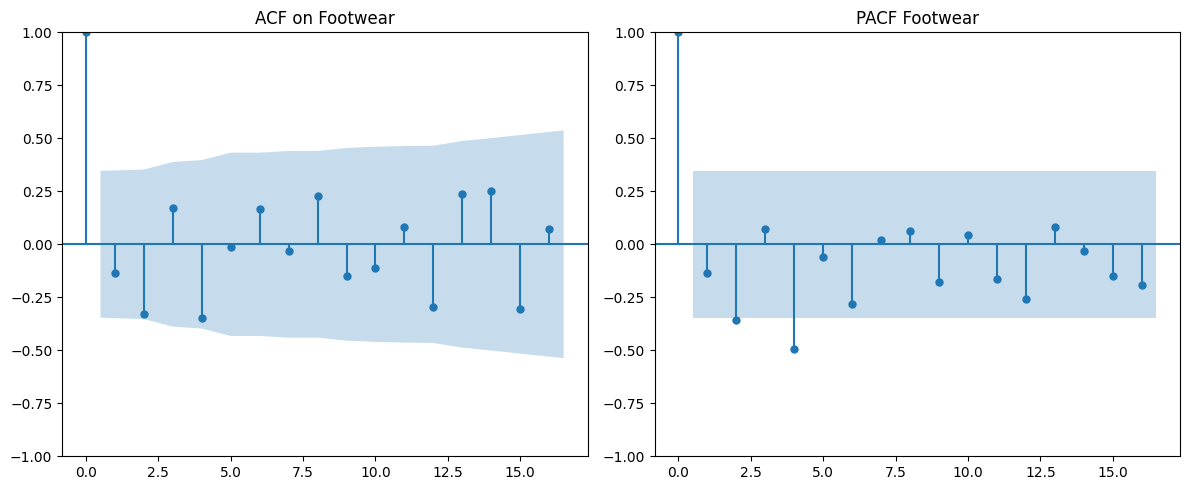

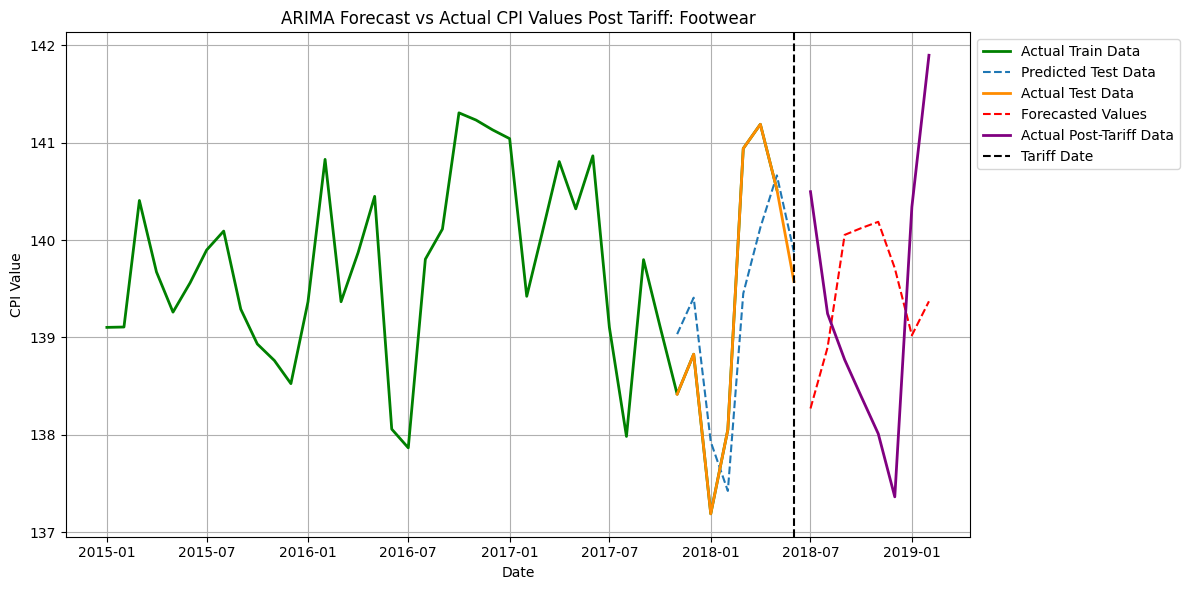


📊 **Augmented Dickey-Fuller (ADF) Test on Differenced Data:**
  p-value: 0.0000 (Stationary ✅)

📊 **In-Sample Evaluation Metrics**
    MAE = 0.4656, MAEP = 0.42%
    RMSE = 0.5381

**Ljung-Box Test (Residuals Autocorrelation):**
  p-value: 0.1700 (No autocorrelation ✅)

📊 **Breusch-Pagan Test (Heteroskedasticity):**
  p-value: 0.3380 (Homoskedastic ✅)

📊 **Model Selection Criteria:**
  AIC: 58.6560


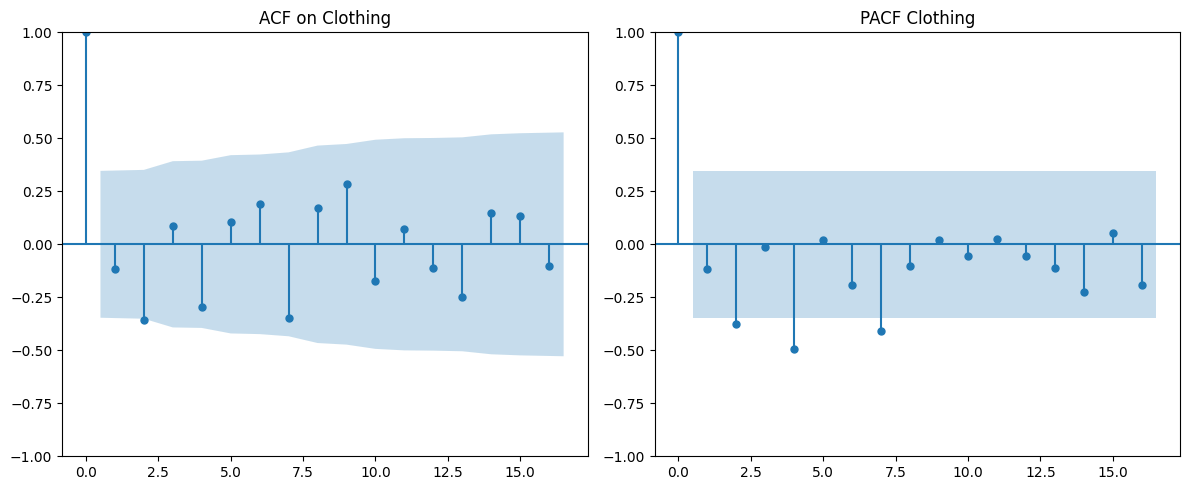

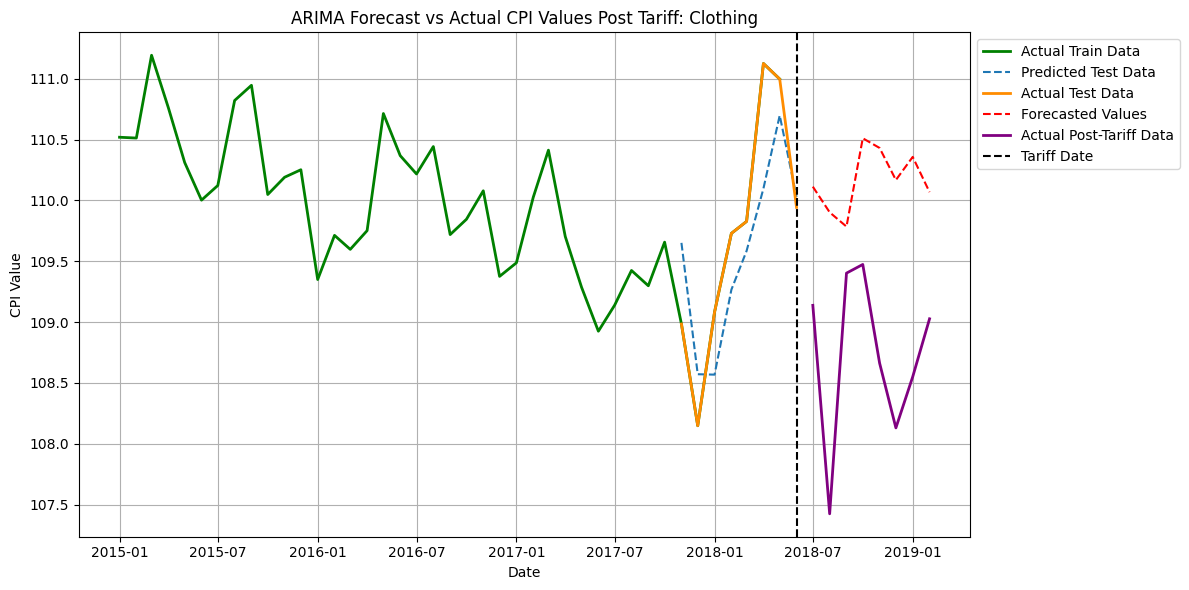


📊 **Augmented Dickey-Fuller (ADF) Test on Differenced Data:**
  p-value: 0.0000 (Stationary ✅)

📊 **In-Sample Evaluation Metrics**
    MAE = 0.7841, MAEP = 0.56%
    RMSE = 0.9795

**Ljung-Box Test (Residuals Autocorrelation):**
  p-value: 0.2122 (No autocorrelation ✅)

📊 **Breusch-Pagan Test (Heteroskedasticity):**
  p-value: 0.7079 (Homoskedastic ✅)

📊 **Model Selection Criteria:**
  AIC: 125.9648


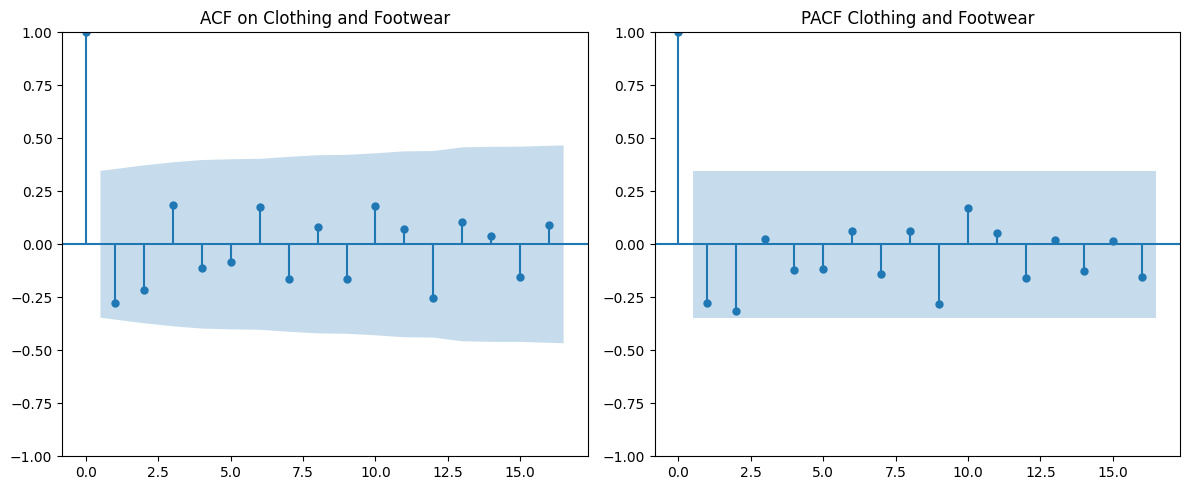

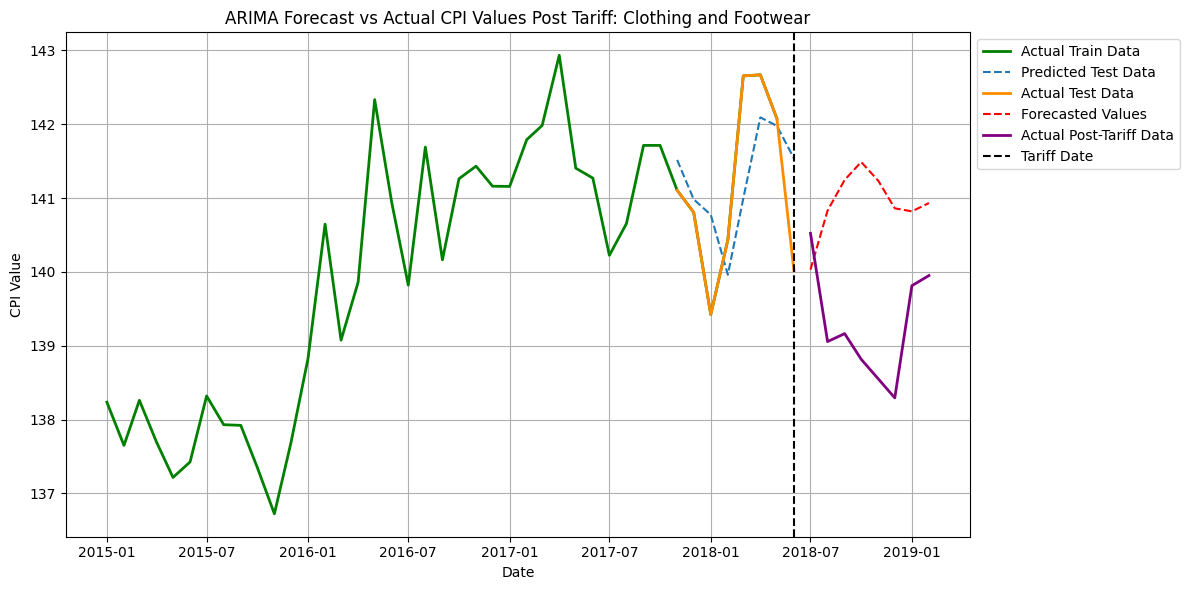


📊 **Augmented Dickey-Fuller (ADF) Test on Differenced Data:**
  p-value: 0.0000 (Stationary ✅)

📊 **In-Sample Evaluation Metrics**
    MAE = 0.3524, MAEP = 0.17%
    RMSE = 0.4923

**Ljung-Box Test (Residuals Autocorrelation):**
  p-value: 0.4978 (No autocorrelation ✅)

📊 **Breusch-Pagan Test (Heteroskedasticity):**
  p-value: 0.0415 (Heteroskedastic ❌)

📊 **Model Selection Criteria:**
  AIC: 72.0949


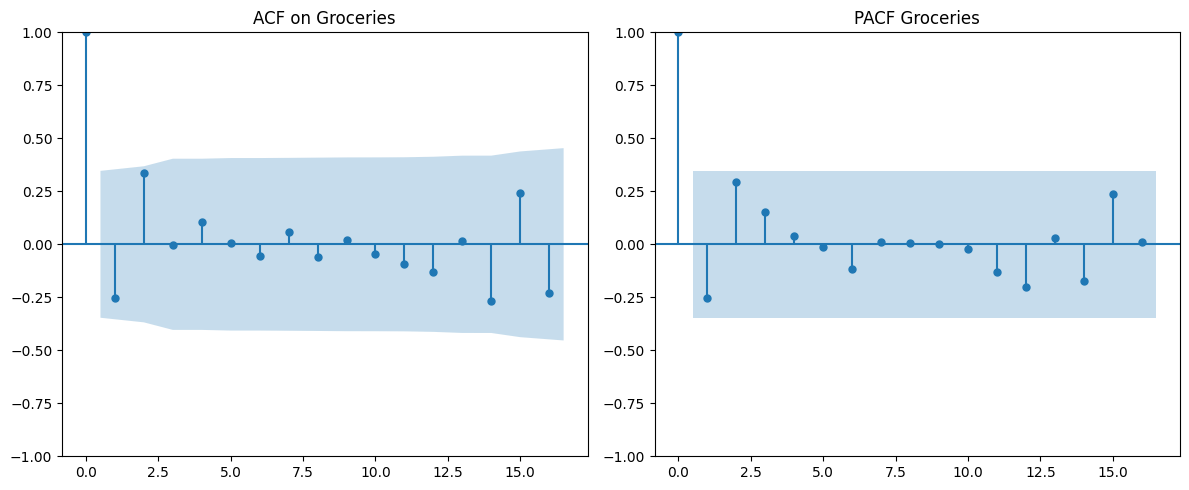

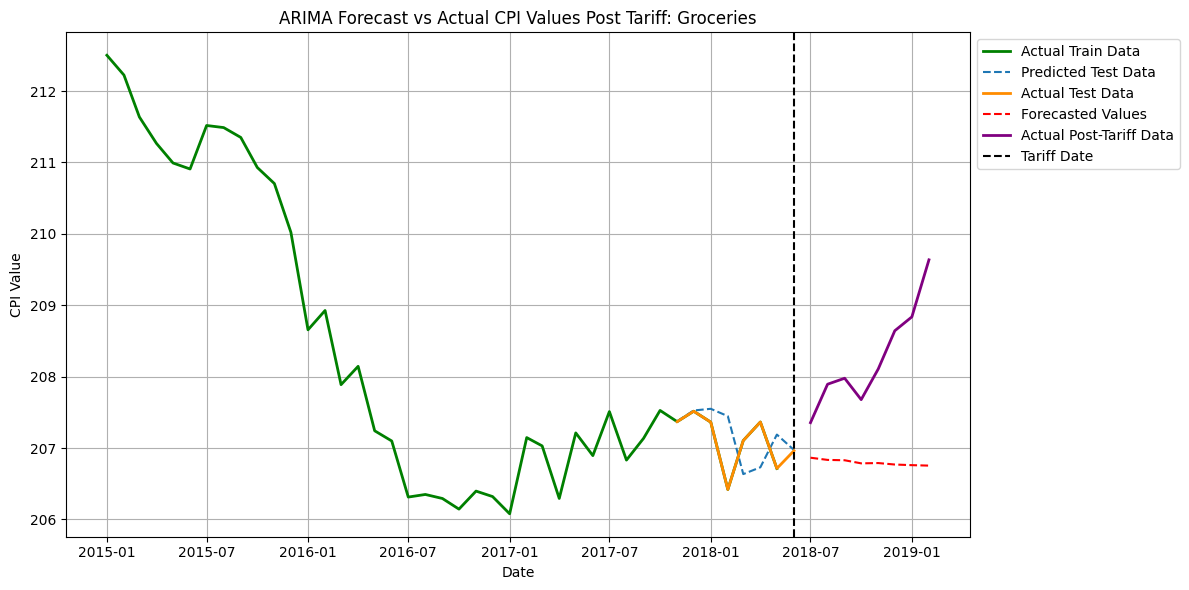


📊 **Augmented Dickey-Fuller (ADF) Test on Differenced Data:**
  p-value: 0.0000 (Stationary ✅)

📊 **In-Sample Evaluation Metrics**
    MAE = 1.4125, MAEP = 0.60%
    RMSE = 1.9852

**Ljung-Box Test (Residuals Autocorrelation):**
  p-value: 0.9362 (No autocorrelation ✅)

📊 **Breusch-Pagan Test (Heteroskedasticity):**
  p-value: 0.0571 (Homoskedastic ✅)

📊 **Model Selection Criteria:**
  AIC: 197.1992


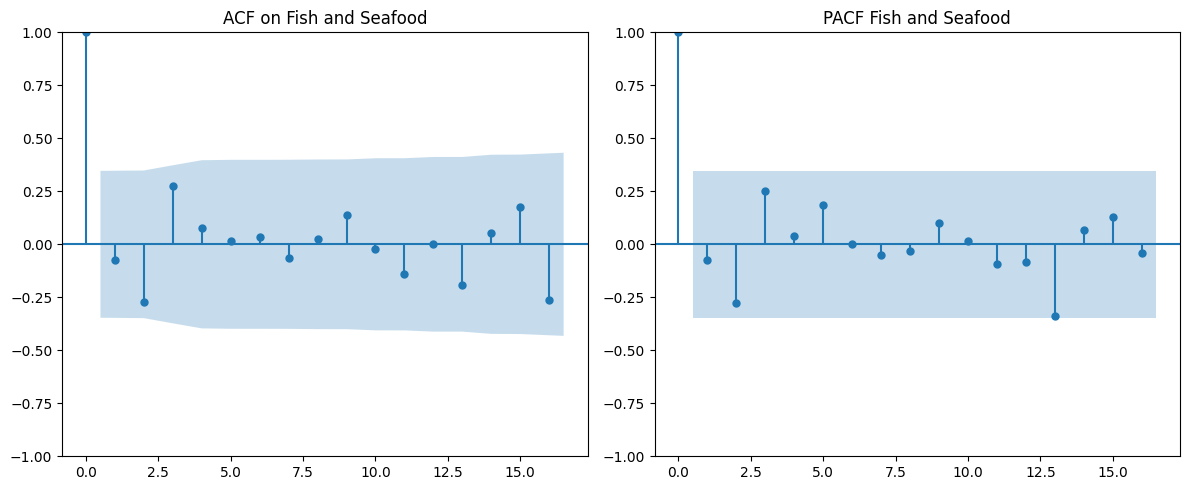

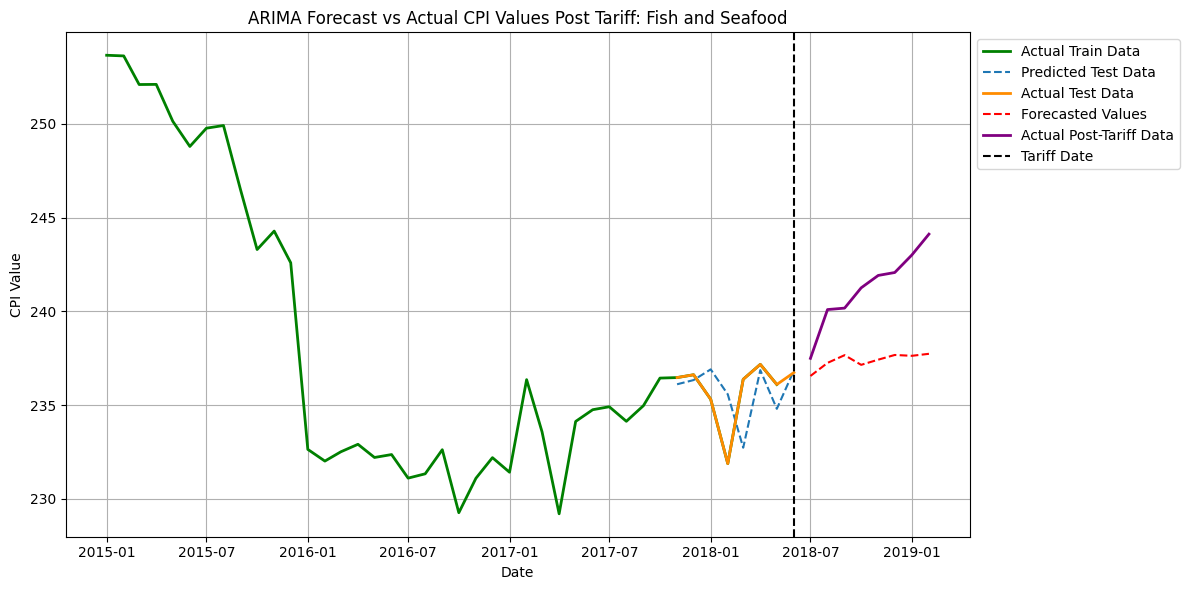


📊 **Augmented Dickey-Fuller (ADF) Test on Differenced Data:**
  p-value: 0.0000 (Stationary ✅)

📊 **In-Sample Evaluation Metrics**
    MAE = 0.4926, MAEP = 0.23%
    RMSE = 0.5903

**Ljung-Box Test (Residuals Autocorrelation):**
  p-value: 0.0861 (No autocorrelation ✅)

📊 **Breusch-Pagan Test (Heteroskedasticity):**
  p-value: 0.0342 (Heteroskedastic ❌)

📊 **Model Selection Criteria:**
  AIC: 115.1924


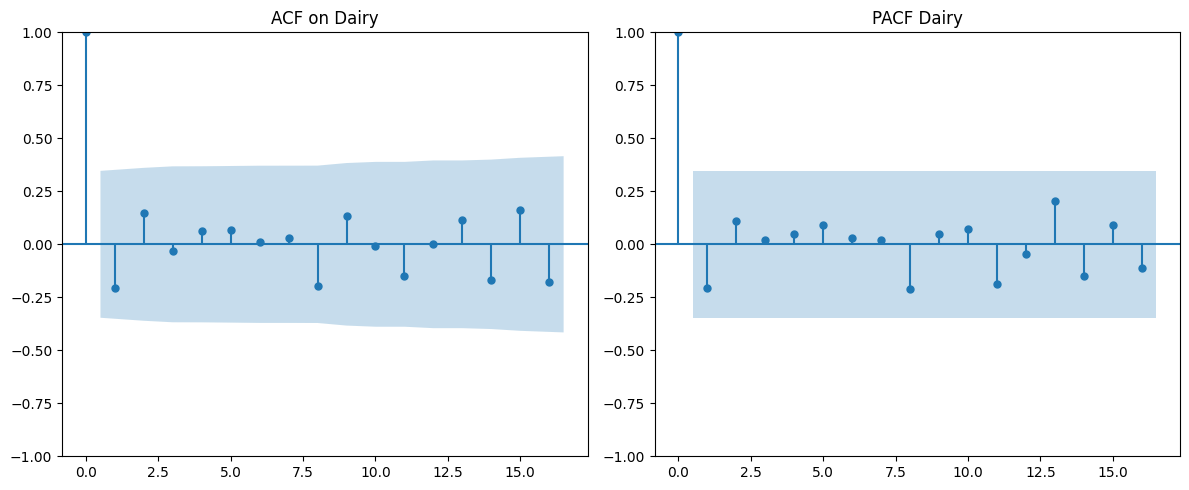

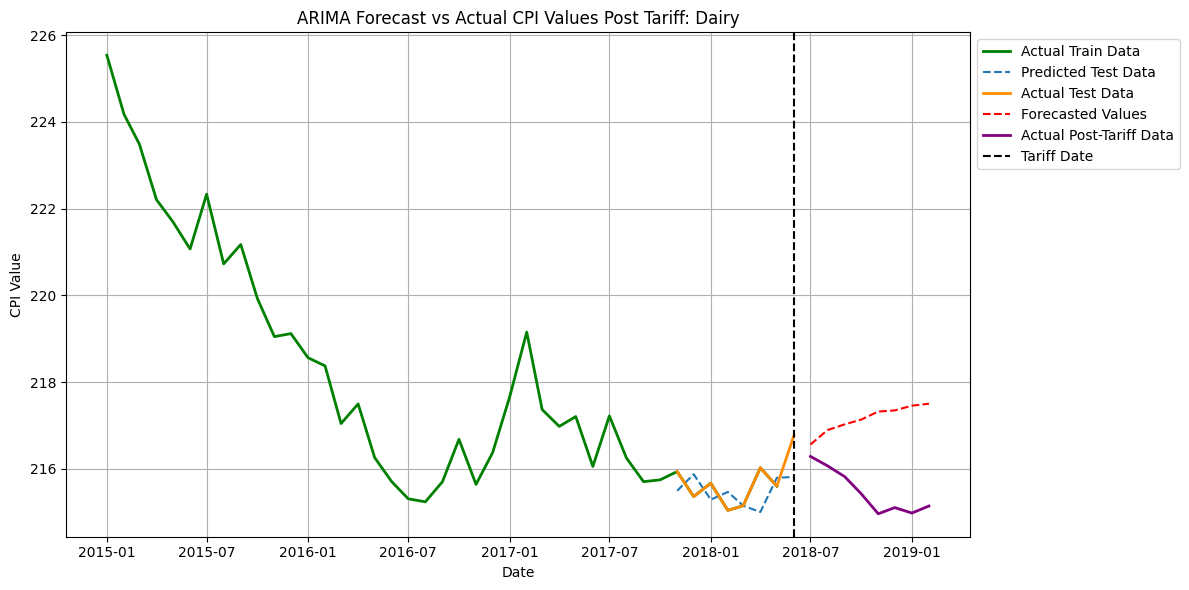

In [11]:
# List of forecasts to make for report
us_cat_list = ['Footwear', 'Clothing', 'Clothing and Footwear', 'Groceries', 'Fish and Seafood', 'Dairy']

# Getting forecasts for report categories per-tariff to post-tariff
for i in us_cat_list:
    model = arima_model(shelter_clothing_df, i, (5,1,0), '2018-06-1', 8, 8)
    plot_acf_pcf(shelter_clothing_df, i, '2017-10-1', lags=16)
    plot_arima_results(shelter_clothing_df, i, model)


📊 **Augmented Dickey-Fuller (ADF) Test on Differenced Data:**
  p-value: 0.0000 (Stationary ✅)

📊 **In-Sample Evaluation Metrics**
    MAE = 5.8615, MAEP = 2.47%
    RMSE = 7.0588

**Ljung-Box Test (Residuals Autocorrelation):**
  p-value: 0.0103 (Residuals correlated ❌)

📊 **Breusch-Pagan Test (Heteroskedasticity):**
  p-value: 0.6659 (Homoskedastic ✅)

📊 **Model Selection Criteria:**
  AIC: 305.4761


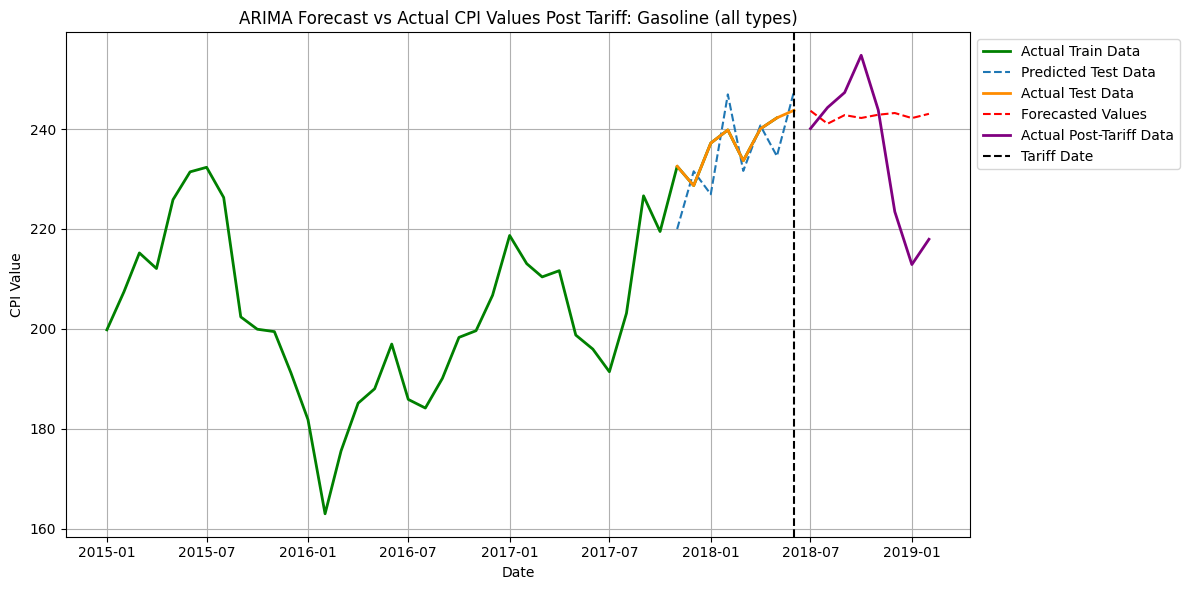

In [12]:
# Calling from original dataframe as we decided to add gasoline later on and it is not included in the shelter_clothing_df
model = arima_model(df_pivoted, 'Gasoline (all types)', (5,1,1), '2018-06-1', 8, 8)
plot_arima_results(df_pivoted, 'Gasoline (all types)', model)

/Users/richardwcheng/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/richardwcheng/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/richardwcheng/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


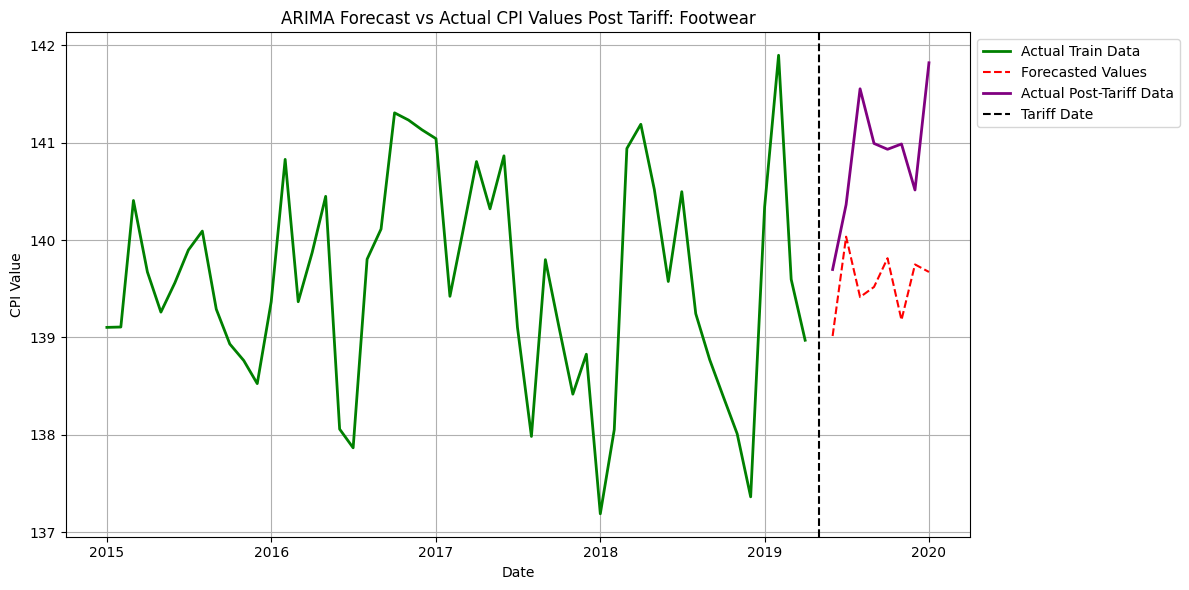

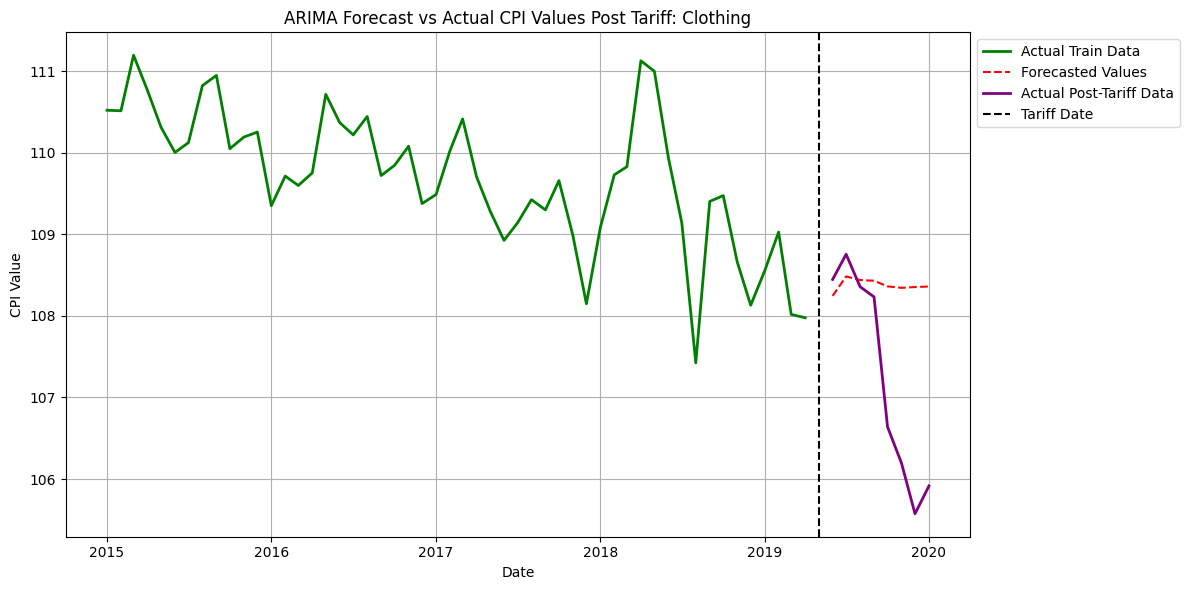

/Users/richardwcheng/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/richardwcheng/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/richardwcheng/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


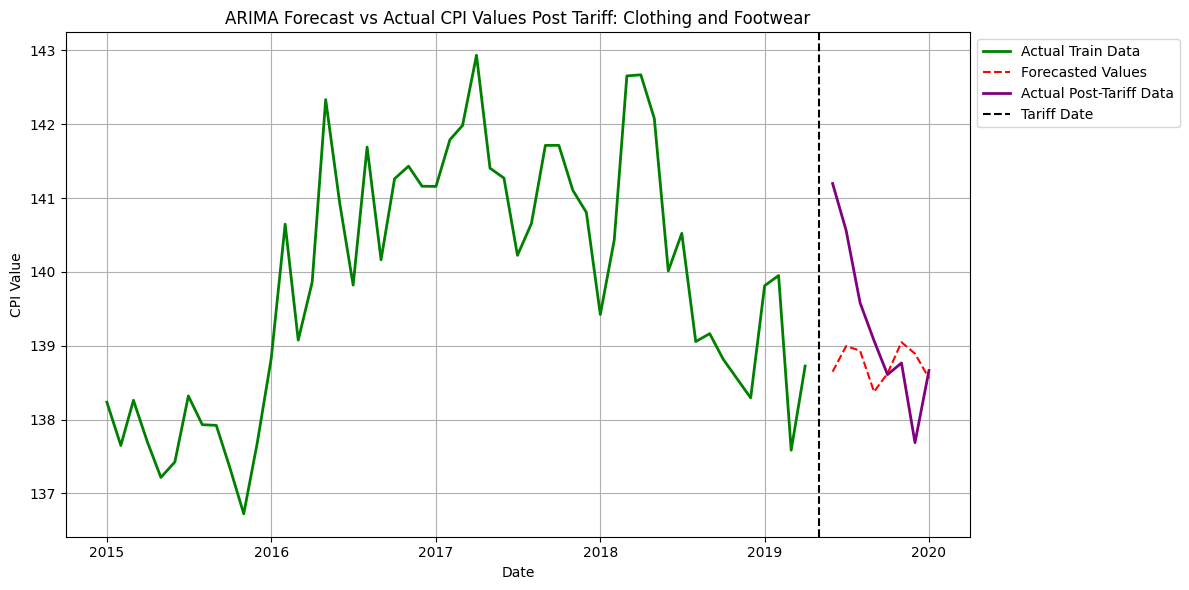

/Users/richardwcheng/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/richardwcheng/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/richardwcheng/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


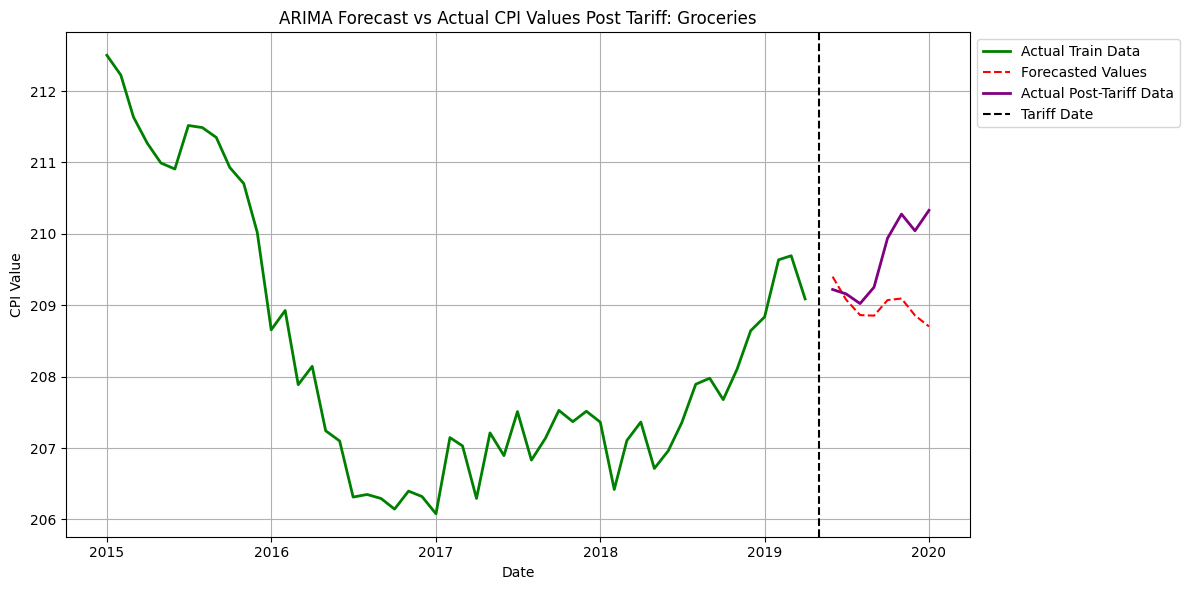

/Users/richardwcheng/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


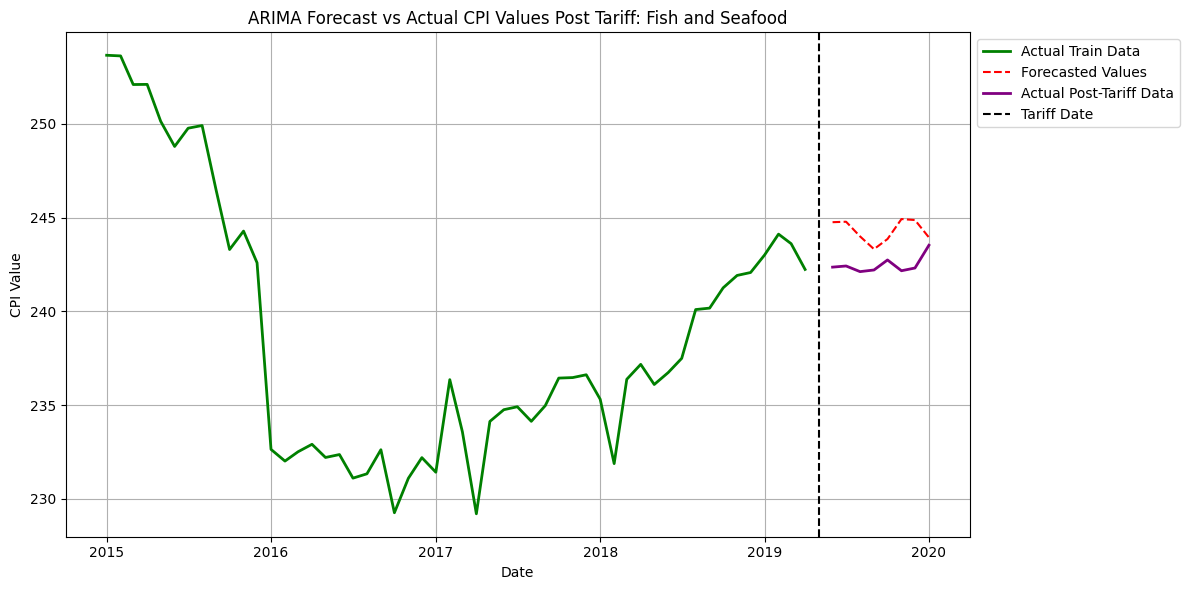

/Users/richardwcheng/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/richardwcheng/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/richardwcheng/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


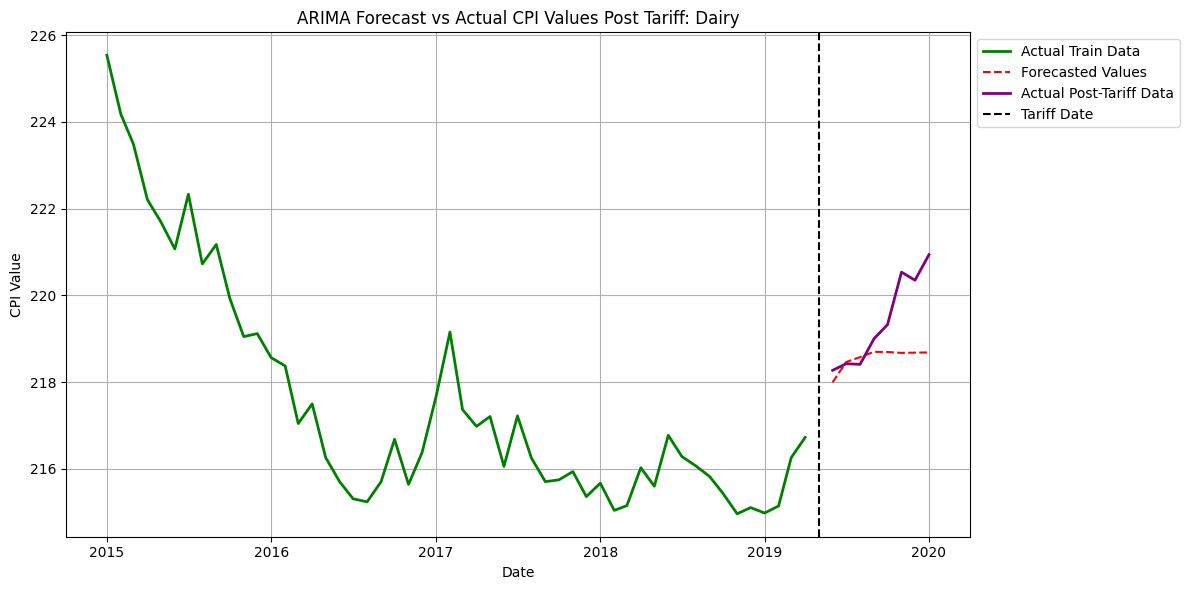

In [13]:
# Getting report category forecasts and visualizations for tariff period to post-tariff period
for i in us_cat_list:
    model = arima_model(shelter_clothing_df, i, (5,1,3), '2019-05-01', 8)
    plot_arima_results(shelter_clothing_df, i, model)

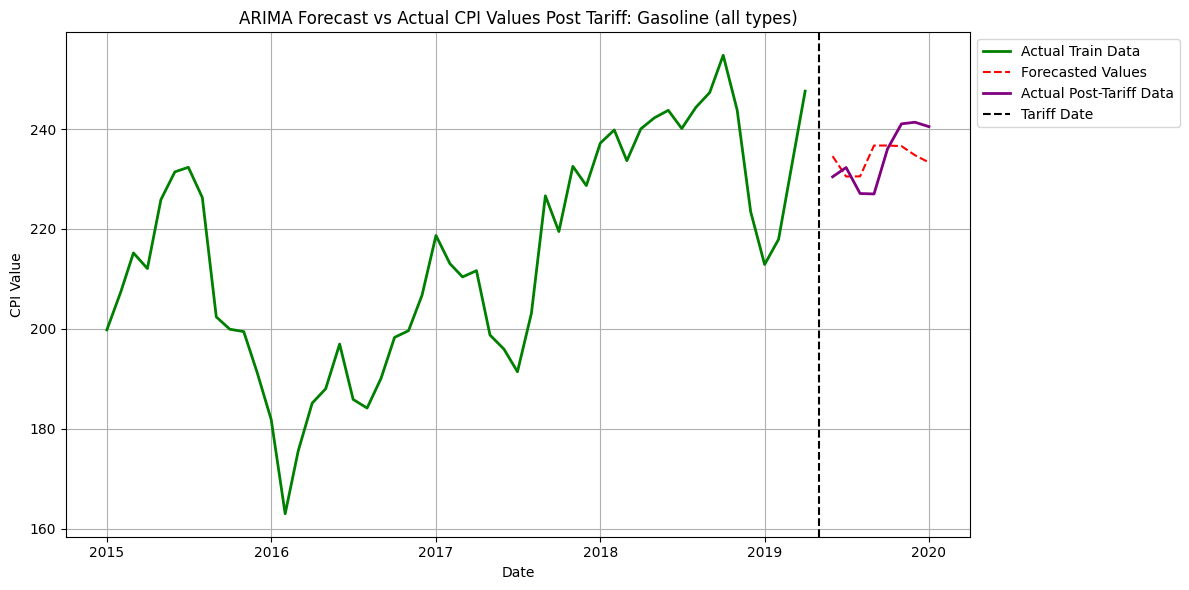

In [14]:
model = arima_model(df_pivoted, 'Gasoline (all types)', (5,1,1), '2019-05-1', 8)
plot_arima_results(df_pivoted, 'Gasoline (all types)', model)